In [36]:
import pandas as pd

data=pd.read_csv("MeMas_5min.csv",header=0,infer_datetime_format=True,parse_dates=['Data'],index_col=['Data'])
daily_data=data.resample('D').sum()
daily_data

,Ativa
Data,
2018-04-22,15225.84
2018-04-23,27092.16
2018-04-24,27735.12
2018-04-25,28000.80
2018-04-26,29124.00
...,...
2020-02-11,21734.64
2020-02-12,21433.68
2020-02-13,21848.40


<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

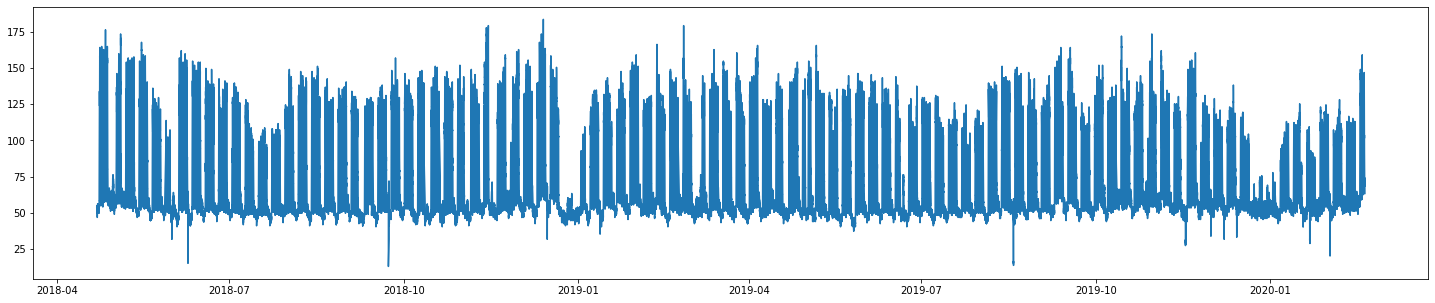

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,5))
plt.plot(data)
plt.grid

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

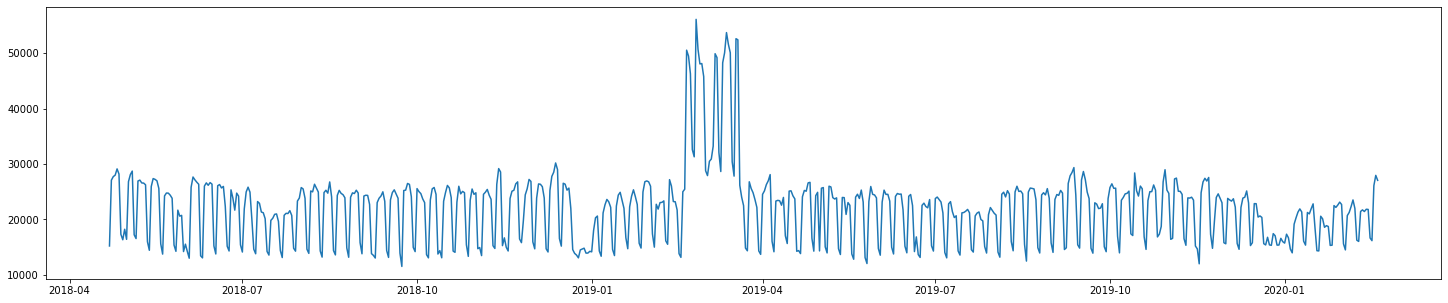

In [34]:
plt.figure(figsize=(25,5))
plt.plot(daily_data)
plt.grid

In [46]:
from sklearn.metrics import mean_squared_error
import numpy as np

def forecasts(act,pred):
    scores=[]
    for i in range(act.shape[1]):
        mse=mean_squared_error(act[:,i],pred[:,i])
        rmse=np.sqrt(mse)
        scores.append(rmse)
    s=0
    for row in range(act.shape[0]):
        for col in range(act.shape[1]):
            s+=(act[row,col]-pred[row,col])**2
    score=np.sqrt(s/(act.shape[0]*act.shape[1]))
    return score,scores

Primeiramnete é necessário separar os dados por semanas inteiras, no conjunto de dados já deixei o primeiro dia sendo um domingo e o último sendo um sábado. No total são 95 semanas, 71 dessas semanas serão utilizadas para o treinamento do modelo e as outras 24 para a validação.

In [59]:
def split(data):
    train,test=data[0:497],data[496:-1]
    train=np.array(np.split(train,len(train)/7))
    test=np.array(np.split(test,len(test)/7))
    return train,test

In [38]:
def summarized_scores(name,score,scores):
    s_scores=', '.join(['%.1f'%s for s in scores])
    print('%s:[%.3f] %s'%(name,score,s_scores))

In [39]:
def to_supervized(train,n_in,n_out):
    data=train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
    X,y=[],[]
    in_start=0
    for i in range(len(data)):
        in_end=in_start+n_in
        out_end=in_end+n_out
        if out_end<len(data):
            x_in=data[in_start:in_end,0]
            x_in=x_in.reshape((len(x_in),1))
            X.append(x_in)
            y.append(data[in_end:out_end,0])
        in_start+=1
    return np.array(X),np.array(y)

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

Using TensorFlow backend.


In [42]:
def build_model(train,n_input):
    train_x,train_y=to_supervized(train,n_input,7)
    verbose=0
    epochs=70
    batch_size=16
    n_timesteps=train_x.shape[1]
    n_features=train_x.shape[2]
    n_outputs=train_y.shape[1]
    model=Sequential()
    model.add(LSTM(200,activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse',optimizer='adam')
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose)
    return model

In [43]:
def forecast(model,history,n_input):
    data=np.array(history)
    data=data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
    in_x=data[-n_input:,0]
    in_x=in_x.reshape((1,len(in_x),1))
    yhat=model.predict(in_x,verbose=0)
    return yhat[0]

In [44]:
def evaluate_model(train,test,n_input):
    model=build_model(train,n_input)
    history=[x for x in train]
    prediction=[]
    for i in range(len(test)):
        yhat_s=forecast(model,history,n_input)
        prediction.append(yhat_s)
        history.append(test[i,:])
    prediction=np.array(prediction)
    score,scores=forecasts(test[:,:,0],prediction)
    return score,scores

In [60]:
train,test=split(daily_data.values)

In [61]:
train.shape

(71, 7, 1)

^ 71 semanas para o treinamento

In [63]:
test.shape

(24, 7, 1)

^ 24 semanas para a validação

In [122]:
score,scores=evaluate_model(train,test,4)

In [123]:
summarized_scores('lstm',score,scores)

lstm:[3683.295] 4177.3, 3534.1, 4812.7, 3222.7, 2848.1, 2668.9, 4030.5


In [106]:
days=['Dom','Seg','Ter','Qua','Qui','Sex','Sáb']

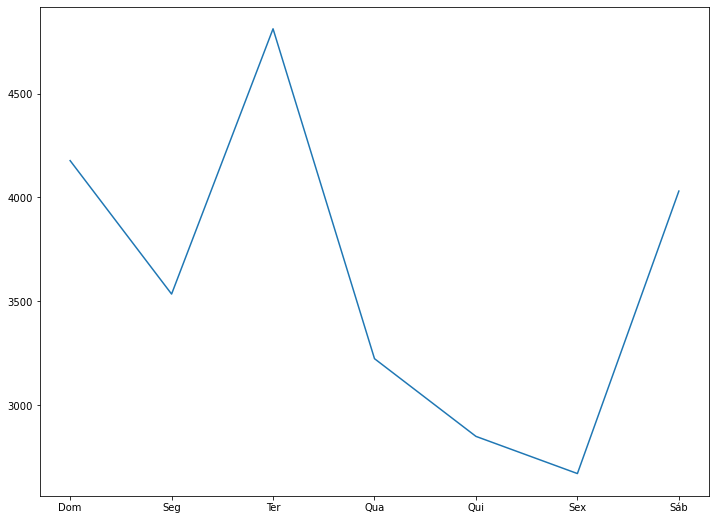

In [124]:
plt.figure(figsize=(12,9))
plt.plot(days,scores)